```
title: Installing Debian
date: 2021-09-16
```

This guide goes over my experience installing Debian 11 alongside Windows 10. Out of the common Linux distros, Ubuntu is out due to Canonical's including of non-free software by default and the whole debacle around [snaps](https://lwn.net/Articles/825005/). For a quick TL;DR: snaps follow a similar theme to Docker images or static builds in that they include the world alongside their package to avoid any "this distro is missing mycoollibrary.so.123 so my software doesn't run!" issues. While you could just not use snaps, some packages, namely `chromium-browser` was changed in apt to surreptitiously install the snap version. Most Linux users balk at the thought of telemetry, and so there is probably no good tracking of the popularity of each distro in the wild (as it should be). However, StackOverflow provides a [nice blurry window](https://insights.stackoverflow.com/trends?tags=ubuntu%2Cdebian%2Cfedora%2Ccentos) (https://superuser.com/ would be cool to look at too but they don't publish insights like this from what I can tell):

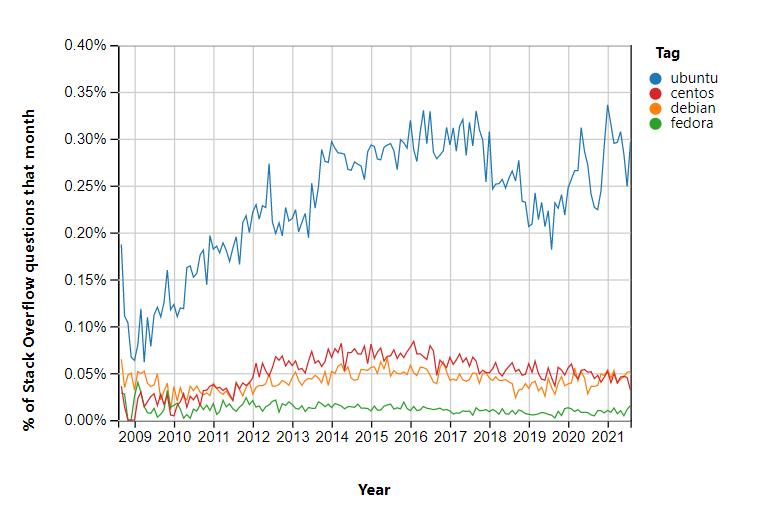

These could mean that Ubuntu is the most popular or that it is the most confusing and everyone is having a great time using Fedora with no issues, but that's probably not the case. A quick peek at Docker image downloads of [Ubuntu](https://hub.docker.com/_/ubuntu) vs [Debian](https://hub.docker.com/_/debian) vs [Fedora](https://hub.docker.com/_/fedora) put Ubuntu ahead by 20 times and Debian by 10. Debian is nice since it has good compatibility with the popular apt packages for Ubuntu, but with a focus on free software. It also supports nice things like disk encryption out of the box during setup.

Copy over the image after downloading a pre-built version:

```bash
# on MacOS
$ diskutil list
$ dd if=debian.img of=/dev/disk2 bs=4m
dd: /dev/disk2: Resource busy
$ diskutil unmoundDisk /dev/disk2  # unmount the disk so it won't be held up by any other processes
$ dd if=debian.img of=/dev/disk2 bs=4m
```

Great, that doesn't work, it just sits there. Checking it out further doesn't really help either:

```bash
$ ps -ax | grep dd | grep -i debian
88647 ttys000    0:00.03 sudo dd if=debian.iso of=/dev/disk2 bs=4m
88648 ttys000    0:09.70 dd if=debian.iso of=/dev/disk2 bs=4m
$ sudo dtruss -p 88647  # also just sits there with no output
dtrace: system integrity protection is on, some features will not be available

SYSCALL(args) 		 = return
$ sudo dtruss -p 88648  # also just sits there with no output
dtrace: system integrity protection is on, some features will not be available

SYSCALL(args) 		 = return
dtrace: error on enabled probe ID 1683 (ID 177: syscall::read:return): invalid user access in action #5 at DIF offset 0
dtrace: error on enabled probe ID 1681 (ID 179: syscall::write:return): invalid user access in action #5 at DIF offset 0
...
```

Not very helpful. MacOS's [System Integrity Protection](https://support.apple.com/en-us/HT204899) is blocking attempts to watch some of the syscalls of `dd`. Running it on a fresh `dd` shows some syscalls though:

```
dtrace: error on enabled probe ID 1696 (ID 317: syscall::munmap:return): invalid user access in action #5 at DIF offset 0
dtrace: error on enabled probe ID 1696 (ID 317: syscall::munmap:return): invalid user access in action #5 at DIF offset 0
dtrace: error on enabled probe ID 1696 (ID 317: syscall::munmap:return): invalid user access in action #5 at DIF offset 0
dtrace: error on enabled probe ID 1696 (ID 317: syscall::munmap:return): invalid user access in action #5 at DIF offset 0
thread_selfid(0x1, 0x0, 0x0)		 = 4300188 0
```

So why is `thread_selfid` OK to view but not `munmap`? No idea.

Killing `dd` with Ctrl-C shows `1761607680 bytes transferred in 678.283557 secs (2597155 bytes/sec)`, meaning some data was transferred, about 1.6 GB worth, and the Debian `.iso` is 1.9 GB so maybe it would have been fine if I left it. A progress bar would alleviate my concerns. `dd` can be coerced into outputting its progress while running with an `INFO` signal sent from another terminal:

```bash
$ set PID (ps -ax | grep -i debian | head -n 1 | awk '{print $1}')
$ sudo kill -s INFO $PID
```

The transfer rate is sitting at about 2 MB/s, well below the USB 2.0 limit of 480 MB/s and still far below the USB 1.1 limit of 12 MB/s. The [likely culprit](https://en.wikipedia.org/wiki/USB_flash_drive#File_transfer_speeds) is a slow USB controller on the flash drive itself (it is almost 8 years old so that might explain it...). All this to say `dd` is confusing and [Etcher](https://www.balena.io/etcher/) is easy so I just used that instead.


## Set Up

I chose GNOME as the window manager during setup, but found it lacking due some annoyances (e.g. meta key to open an app by name covers the entire screen) and crashes. KDE Plasma works much more like Windows by default, and obviates the need for third-party settings apps like `gnome-tweaks`.

```bash
$ tasksel  # set up KDE Plasma
```

### Random Settings

* Settings
    * Input Devices > Mouse > Acceleration Profile: Flat
    * Workspace Behavior
        * General Behavior > Animation Speed: Instant
        * Screen Edges > Disable
        * Screen Edges > Disable
* Download [Source Code Pro](https://fonts.google.com/specimen/Source+Code+Pro), move to `~/.fonts` (`.ttf` and `.otf` files stored here are automatically picked up)
   * Konsole > Settings > Appearance > Font: Source Code Pro 12pt
   * Konsole > Settings > Appearance > Color Scheme: Breeze
* Install Nvidia Driver + CUDA

    ```bash
    $ deb http://deb.debian.org/debian/ bullseye main contrib non-free
  $ apt update
    $ apt install -y nvidia-driver firmware-misc-nonfree nvidia-cuda-toolkit
  $ nvidia-smi
    ```
* Firefox > `about:config` > `general.smoothScroll`: false